In [2]:
import sys
sys.path.append('../')

with open('../grail_metabolism/data/reactions.txt') as file:
    rules = file.read().split("', '")

In [41]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdChemReactions
import re
from tqdm import tqdm

def preprocess_smarts(smarts):
    """Улучшенная предобработка SMARTS с сохранением ключевых структур"""
    # Удаляем атомные метки типа [C:1] -> [C]
    smarts = re.sub(r':\d+', '', smarts)
    
    # Заменяем сложные логические операторы на простые атомы
    smarts = re.sub(r'\[[^]]*&[^]]*\]', '[#6]', smarts)  # Логическое И
    smarts = re.sub(r'\[[^]]*;[^]]*\]', '[#6]', smarts)  # Логическое ИЛИ
    
    # Упрощаем сложные конструкции с NOT
    smarts = re.sub(r'\[!\w+[^]]*\]', '[#6]', smarts)
    
    # Удаляем стереохимические маркеры
    smarts = re.sub(r'@[a-zA-Z0-9]+\b', '', smarts)
    
    # Заменяем редкие атомы на общие шаблоны
    smarts = re.sub(r'\[[A-Za-z]{2,}\]', '[#6]', smarts)  # Редкие элементы
    
    return smarts

def rule_to_fingerprint(rule, fp_size=8192, radius=4):
    """Устойчивое преобразование правил реакции в отпечаток"""
    try:
        if '>>' not in rule:
            return None
            
        # Извлекаем левую часть реакции (субстраты)
        left_part = rule.split('>>')[0].strip()
        
        # Удаляем внешние скобки если они есть
        if left_part.startswith('(') and left_part.endswith(')'):
            left_part = left_part[1:-1]
        
        # Предобработка
        left_part = preprocess_smarts(left_part)
        
        # Разбиваем на молекулы
        molecules = []
        current = ""
        depth = 0
        for char in left_part:
            if char == '[':
                depth += 1
            elif char == ']':
                depth -= 1
            elif char == '.' and depth == 0:
                if current:
                    molecules.append(current)
                    current = ""
                continue
            current += char
        if current:
            molecules.append(current)
        
        # Создаем объединенный отпечаток для всех молекул
        combined_fp = None
        valid_count = 0
        
        for mol_str in molecules:
            try:
                # Пытаемся создать молекулу из SMARTS
                mol = Chem.MolFromSmarts(mol_str)
                if mol is None:
                    # Пробуем альтернативный подход: создание из SMILES
                    mol = Chem.MolFromSmiles(mol_str)
                
                if mol is not None:
                    fp = AllChem.GetMorganFingerprintAsBitVect(
                        mol, radius, nBits=fp_size, useFeatures=True
                    )
                    if combined_fp is None:
                        combined_fp = fp
                    else:
                        combined_fp = combined_fp | fp  # Объединение через ИЛИ
                    valid_count += 1
            except:
                continue
        
        return combined_fp if valid_count > 0 else None
    except:
        return None

def cluster_smarts_rules(smarts_rules, target_clusters=500, tolerance=50, 
                         fp_size=8192, radius=4):
    """Кластеризация правил с расширенной обработкой ошибок"""
    fingerprints = []
    valid_rules = []
    
    print("Обработка правил...")
    for rule in tqdm(smarts_rules):
        fp = rule_to_fingerprint(rule, fp_size, radius)
        if fp is not None:
            fingerprints.append(fp)
            valid_rules.append(rule)
    
    print(f"Успешно обработано: {len(valid_rules)}/{len(smarts_rules)} правил")
    
    if not valid_rules:
        print("Не удалось обработать ни одного правила")
        return []
    
    # Создаем фиктивные отпечатки для необработанных правил
    if len(valid_rules) < len(smarts_rules):
        num_missing = len(smarts_rules) - len(valid_rules)
        print(f"Создаем фиктивные отпечатки для {num_missing} необработанных правил")
        dummy_fp = AllChem.GetMorganFingerprintAsBitVect(
            Chem.MolFromSmiles('C'), radius, nBits=fp_size
        )
        for _ in range(num_missing):
            modified_fp = dummy_fp.ToBitString()
            # Немного изменяем фиктивные отпечатки
            modified_fp = modified_fp[:1000] + '0' + modified_fp[1001:]
            fingerprints.append(DataStructs.CreateFromBitString(modified_fp))
            valid_rules.append("INVALID_RULE_PLACEHOLDER")
    
    n = len(fingerprints)
    
    # Вычисление матрицы расстояний
    print("Вычисление попарных расстояний...")
    dists = []
    for i in tqdm(range(1, n)):
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        dists.extend([1 - x for x in sims])
    
    # Адаптивная кластеризация
    print("Кластеризация...")
    clusters = Butina.ClusterData(dists, n, 0.2, isDistData=True)
    print(f"Первоначально образовано кластеров: {len(clusters)}")
    
    # Автоматическая настройка для достижения целевого числа кластеров
    thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    best_clusters = clusters
    best_threshold = 0.2
    best_diff = abs(len(clusters) - target_clusters)
    
    for threshold in thresholds:
        clusters = Butina.ClusterData(dists, n, threshold, isDistData=True)
        diff = abs(len(clusters) - target_clusters)
        if diff < best_diff:
            best_diff = diff
            best_clusters = clusters
            best_threshold = threshold
    
    # Выбор представителей
    representatives = []
    for cluster in best_clusters:
        cluster_rules = [valid_rules[i] for i in cluster]
        # Фильтруем невалидные правила
        valid_cluster_rules = [r for r in cluster_rules if "INVALID_RULE_PLACEHOLDER" not in r]
        
        if valid_cluster_rules:
            # Выбираем самое короткое валидное правило
            representative = min(valid_cluster_rules, key=len)
        else:
            # Если в кластере только невалидные, берем первое
            representative = cluster_rules[0]
        representatives.append(representative)
    
    print(f"Образовано кластеров: {len(best_clusters)} (порог: {best_threshold:.3f})")
    return representatives

reduced_rules = cluster_smarts_rules(
    rules,
    target_clusters=500,
    tolerance=50,
    fp_size=16000,
    radius=4
)

final_rules = [r for r in reduced_rules if "INVALID_RULE_PLACEHOLDER" not in r]
print(f"Финальное количество правил: {len(final_rules)}")

Обработка правил...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4533/4533 [00:03<00:00, 1250.13it/s]


Успешно обработано: 907/4533 правил
Создаем фиктивные отпечатки для 3626 необработанных правил
Вычисление попарных расстояний...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4532/4532 [00:08<00:00, 552.26it/s]


Кластеризация...
Первоначально образовано кластеров: 165
Образовано кластеров: 181 (порог: 0.100)
Финальное количество правил: 180


In [43]:
for rule in final_rules

['[C:1]>>[C:1][O:2]',
 '[C:1][C:2]=[C:3][C:4]>>[C:1][C:2][C:3][C:4]',
 'I[C:2](:[C:1]):[C:3]>>[C:1]:[C:2]:[C:3]',
 'F[C:2][C:1]>>[C:1][C:2][O:3]',
 '[C:1][C:3]=[C:2]>>[C:1][C:2][C:3]',
 '[C][C]=[C:2]([C])[C:1]>>[C:1][C:2]([O:3])=[O:4]',
 '[C][C][C:1][C:2]>>[C:1][C:2]',
 '[C:1]=[C:2]([C:3])[C:4]>>[C:1][C:2]([C:3])[C:4]',
 '[C][C]=[C:3]([C:2][C:1])[C:4]>>[C:1][C:2][C:3][C:4]',
 '[C][C:3]([C])[C:2][C:1]>>[C:1][C:2][C:3]',
 '[C:1][c:2]1[c:3][c:4][c:6][c:8][c:7]1>>[C:1][C:2]1=[C:3][C:4]2[O:5][C:6]2[C:7]=[C:8]1',
 '[C:1][c:2]1[c:3][c:4][c:6][c:7][c:8]1[C:9]>>[C:1][C:2]1=[C:3][C:4]2[O:5][C:6]2[C:7]=[C:8]1[C:9]',
 '[C:1][C:2]([C:3])=[C:4]([C:5])[C:6]>>[C:1][C:2]([C:3])[C:4]([C:5])[C:6]',
 '[C][C:2]([C])[C:1]>>[C:1][C:2]',
 'F[C:2]([C:1])[C:3]>>[C:1][C:2][C:3]',
 '[C][C][C:1][C:2]=[C:3][C:4]>>[C:1][C:2]=[C:3][C:4]',
 '[C][C:2](:[C:1]):[C:3]>>[C:1]:[C:2]:[C:3]',
 's1[c:4][c:3][c:2]([C:1])[c:6]1[C:7]>>[C:1][c:2]1[c:3][c:4][o:5][c:6]1[C:7]',
 '([C:5].[C:1]([C:2](:[C:3]):[C:4])[C:6])>>([C:1][C:2](:

In [46]:
import sys
sys.path.append("../")

In [47]:
import pickle as pkl
with open('../grail_metabolism/data/val.pkl', 'rb') as f:
    val = pkl.load(f)

ATTENTION: RXNMapper is not installed. Please install it first if you want to create your own set of rules.
ATTENTION: you use incorrect for rxnmapper version of rdkit


In [3]:
from grail_metabolism.utils.preparation import metaboliser

ATTENTION: RXNMapper is not installed. Please install it first if you want to create your own set of rules.
ATTENTION: you use incorrect for rxnmapper version of rdkit


In [56]:
with open('../grail_metabolism/data/smirks.txt') as f:
    smirks = f.read().splitlines()

In [4]:
with open('../grail_metabolism/data/merged_smirks.txt') as f:
    smirks = f.read().splitlines()

In [ ]:
smirks.extend(final_rules)

In [58]:
merged_rule_set = list(set(smirks))

In [73]:
coverages = []
for substrate in tqdm(val.map):
    mol = Chem.MolFromSmiles(substrate)
    metabolism_rules = metaboliser(mol, rules=merged_rule_set)
    generated = set([Chem.MolToSmiles(x) for x in metabolism_rules.keys()])
    coverage = len(generated & val.map[substrate]) / len(val.map[substrate])
    coverages.append(coverage)

  1%|▉                                                                                                                                                 | 7/1035 [00:12<30:31,  1.78s/it]


KeyboardInterrupt: 

In [64]:
rules_all = rules.copy()

In [65]:
rules_all.extend(smirks)
rules_all = list(set(rules_all))

In [74]:
len(rules_all)

5007

In [69]:
coverages_all = []
for substrate in tqdm(val.map):
    mol = Chem.MolFromSmiles(substrate)
    metabolism_rules = metaboliser(mol, rules=rules_all)
    generated = set([Chem.MolToSmiles(x) for x in metabolism_rules.keys()])
    coverage = len(generated & val.map[substrate]) / len(val.map[substrate])
    coverages_all.append(coverage)

  5%|██████▉                                                                                                                                        | 50/1035 [09:31<3:07:38, 11.43s/it]


KeyboardInterrupt: 

<Axes: >

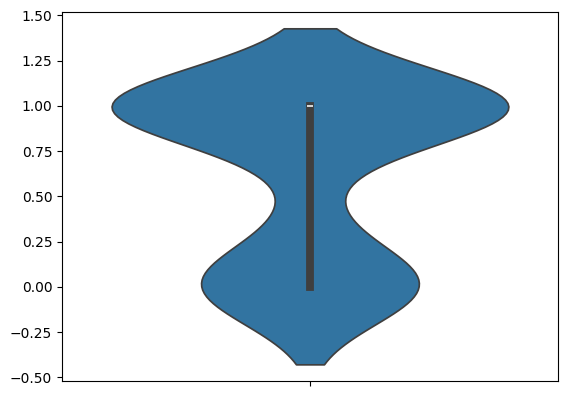

In [71]:
import seaborn as sns
sns.violinplot(coverages_all)

<Axes: >

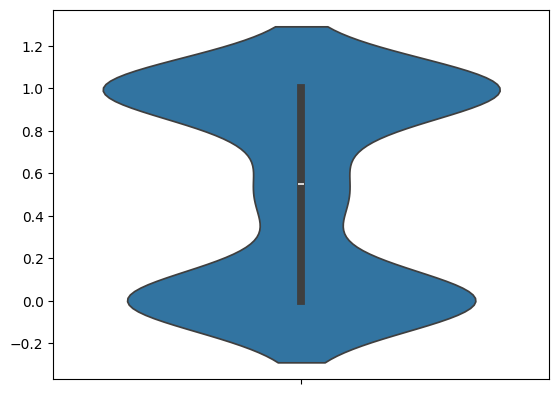

In [63]:
sns.violinplot(coverages)

In [70]:
with open('../grail_metabolism/data/merged_smirks.txt', 'w') as f:
    print(*merged_rule_set, file=f, sep='\n')

In [72]:
len(merged_rule_set)

654

In [75]:
reduced_rules = cluster_smarts_rules(
    rules_all,
    target_clusters=500,
    tolerance=50,
    fp_size=16000,
    radius=4
)

final_rules = [r for r in reduced_rules if "INVALID_RULE_PLACEHOLDER" not in r]
print(f"Финальное количество правил: {len(final_rules)}")

Обработка правил...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5007/5007 [00:03<00:00, 1277.91it/s]


Успешно обработано: 1069/5007 правил
Создаем фиктивные отпечатки для 3938 необработанных правил
Вычисление попарных расстояний...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:10<00:00, 465.90it/s]


Кластеризация...
Первоначально образовано кластеров: 239
Образовано кластеров: 261 (порог: 0.100)
Финальное количество правил: 260


In [78]:
len(smirks)

654

In [5]:
from tqdm.auto import tqdm

In [6]:
from IPython.display import display

In [96]:
smirks.append('[*][C:1](=[O:2])-[O:3]-[*]>>[*][C:1](=[O:2])-[O:3].[O:4]-[*]')

In [7]:
from grail_metabolism.utils.preparation import standardize_mol

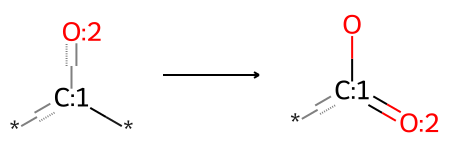

In [104]:
Chem.AllChem.ReactionFromSmarts('[*][C:1]([O:2])-[*]>>[*][C:1](=[O:2])-[O]')

In [108]:
smirks.pop(-1)

'[*][C:1]([O:2])-[*]>>[*][C:1](=[O:2])-[O]'

In [109]:
smirks.append('[*][C:1]([O:2])-[*]>>[*][C:1](=[O:2])-[O].[*]-[O]')

In [112]:
coverages_selected = []
for substrate in tqdm(val.map):
    mol = Chem.MolFromSmiles(substrate)
    metabolism_rules = metaboliser(mol, rules=smirks)
    generated = set([Chem.MolToSmiles(standardize_mol(x)) for x in metabolism_rules.keys()])
    coverage = len(generated & set([standardize_mol(x) for x in val.map[substrate]])) / len(val.map[substrate])
    coverages_selected.append(coverage)

  0%|          | 0/1035 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
coverages_all

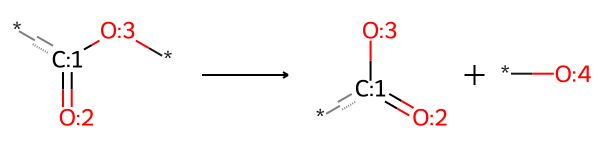

In [94]:
Chem.AllChem.ReactionFromSmarts('[*][C:1](=[O:2])-[O:3]-[*]>>[*][C:1](=[O:2])-[O:3].[O:4]-[*]')

In [113]:
coverages_all = []
for substrate in tqdm(val.map):
    mol = Chem.MolFromSmiles(substrate)
    metabolism_rules = metaboliser(mol, rules=rules_all)
    generated = set([Chem.MolToSmiles(x) for x in metabolism_rules.keys()])
    coverage = len(generated & val.map[substrate]) / len(val.map[substrate])
    coverages_all.append(coverage)

  0%|          | 0/1035 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [130]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Coverage')

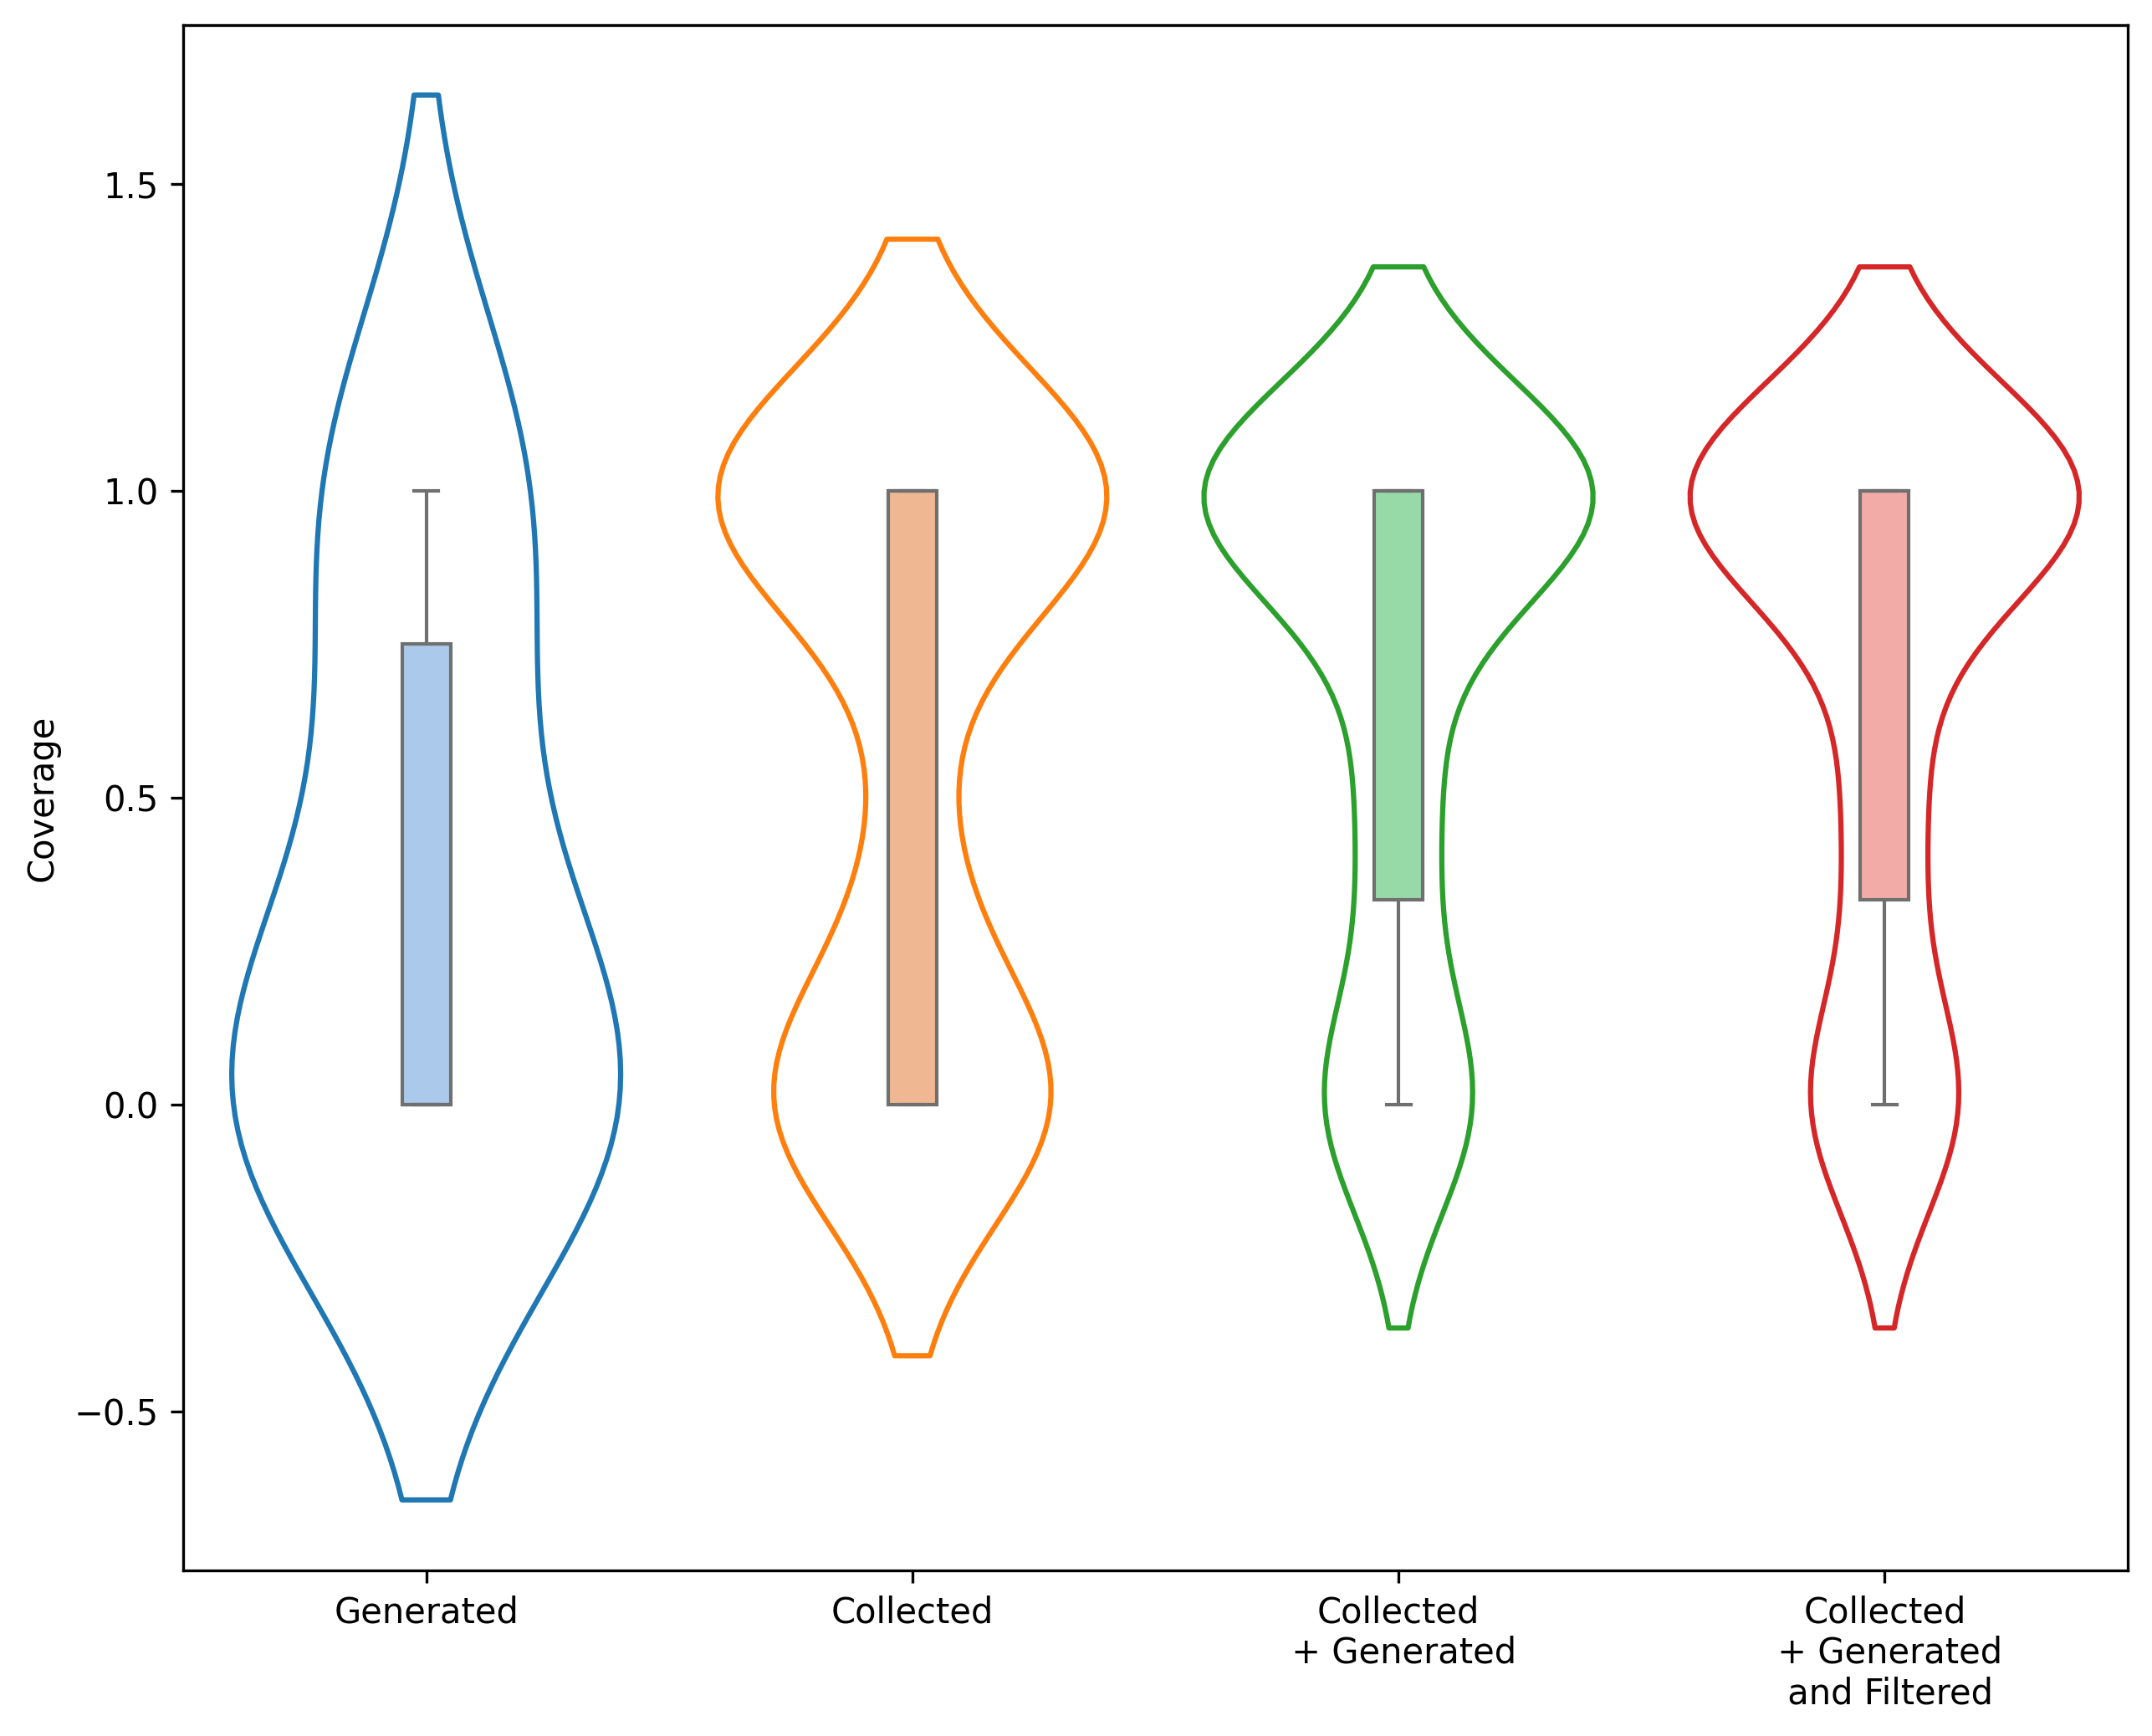

In [143]:
plt.figure(figsize=(10, 8), dpi=300)
sns.violinplot([coverages, coverages_all, coverages_selected, coverages_selected], inner=None, fill=False, )
sns.boxplot([coverages, coverages_all, coverages_selected, coverages_selected], width=0.1, palette='pastel')
plt.xticks(ticks=[0,1,2,3], labels=['Generated', 'Collected', 'Collected\n + Generated', 'Collected\n + Generated\n and Filtered'])
plt.ylabel('Coverage')

In [144]:
with open('../grail_metabolism/data/merged_smirks.txt', 'w') as f:
    print(*smirks, file=f, sep='\n')

In [1]:
import pickle as pkl

In [2]:
import sys
sys.path.append('..')

In [3]:
with open('../grail_metabolism/data/train.pkl', 'rb') as f:
    train = pkl.load(f)

ATTENTION: RXNMapper is not installed. Please install it first if you want to create your own set of rules.
ATTENTION: you use incorrect for rxnmapper version of rdkit


In [4]:
with open('../grail_metabolism/data/merged_smirks.txt') as f:
    smirks = f.read().splitlines()

In [7]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [ ]:
train.label_reactions(smirks)

  0%|          | 0/8977 [00:00<?, ?it/s]

In [6]:
train.reaction_labels

{}